# Import

In [1]:
!pip install lpips

import os
from google.colab import drive
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim
import torch
import lpips


drive.mount('/content/drive')
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/MyWatermarkinClasses.ipynb'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 843.5 kB/s eta 0:00:00
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Image/Test_Grey_512'
# folder_path = '/content/drive/My Drive/Colab Notebooks/Image/Other_512_Images'

training_image_array = []
target_size = (512, 512)  # Resize to desired shape (width, height)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', 'tiff')):
        img_path = os.path.join(folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

        # Resize if needed
        my_image = cv.resize(my_image, target_size)

        # Normalize to [0.0, 1.0]
        im = my_image.astype(np.float32) / 255.0
        #im = my_image.astype(np.float32)

        training_image_array.append(im)

# Main

## Functions

In [17]:
def calculate_psnr(original, distorted):
  """
  Calculate PSNR (Peak Signal-to-Noise Ratio) between two images.

  Parameters:
      original (numpy.ndarray): The original image.
      distorted (numpy.ndarray): The distorted image (same shape as original).

  Returns:
      float: PSNR value in decibels (dB).
  """
  mse = np.mean((original - distorted) ** 2)
  if mse == 0:
      return float('inf')  # No difference, PSNR is infinite

  max_pixel = 1.0 if original.max() <= 1.0 else 255.0  # Choose based on normalization
  psnr = 10 * np.log10((max_pixel ** 2) / mse)
  return psnr


def calculate_ssim(img1, img2):
    """
    img1, img2: numpy arrays (grayscale, normalized [0,1])
    """
    score, _ = ssim(img1, img2, full=True, data_range=1.0)
    return score


def calculate_lpips(img1_np, img2_np, net='alex'):
    """
    img1_np, img2_np: numpy arrays (grayscale, normalized [0,1]), shape = (H, W)
    net: 'alex', 'vgg', or 'squeeze'
    """
    # Convert to torch tensors, shape: (1, 1, H, W)
    img1 = torch.tensor(img1_np).unsqueeze(0).unsqueeze(0)
    img2 = torch.tensor(img2_np).unsqueeze(0).unsqueeze(0)

    # Expand to 3 channels: (1, 3, H, W)
    img1 = img1.repeat(1, 3, 1, 1)
    img2 = img2.repeat(1, 3, 1, 1)

    # Normalize to [-1, 1]
    img1 = img1 * 2 - 1
    img2 = img2 * 2 - 1

    # Load LPIPS model
    loss_fn = lpips.LPIPS(net=net)
    with torch.no_grad():
        dist = loss_fn(img1, img2)
    return dist.item()

## Transparency Evaluation (512 * 512)

PSNR (Original vs. Blurred):        22.30 dB
PSNR (Original vs. Brightened):     6.94 dB
PSNR (Original vs. Contrast):       19.55 dB
PSNR (Original vs. Gaussian Noise): 36.97 dB
PSNR (Original vs. X-Shifted):      11.74 dB
PSNR (Original vs. Rotated):        14.66 dB
PSNR (Original vs. Random Noise):   23.42 dB


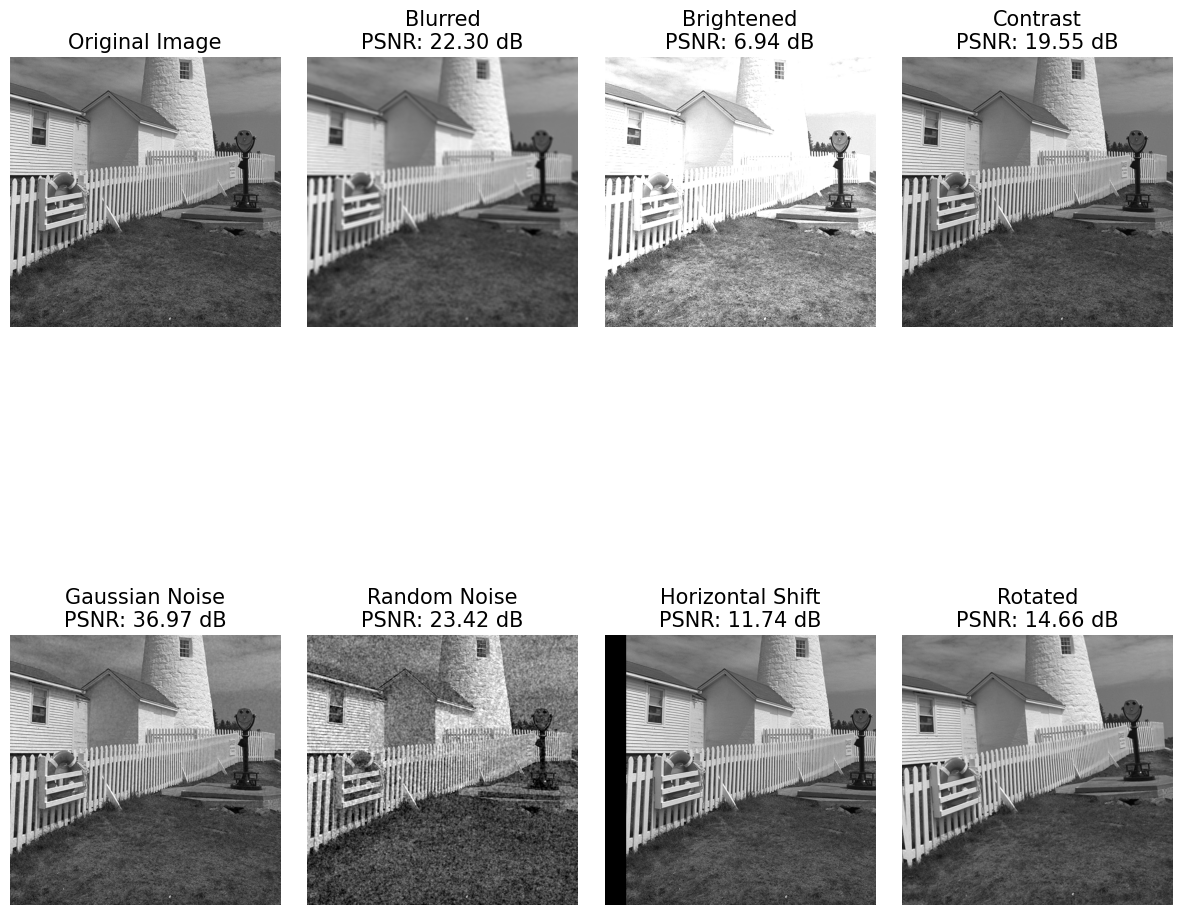

In [63]:
# === Select Input Image ===
_im = training_image_array[0]
im = _im #cv.resize(_im, (128, 128), interpolation=cv.INTER_AREA)


# === Apply Attacks ===
blurred_im = Channel(im).blur_image(5)
brightened_im = Channel(im).brightness_attack(0.5)
contrast_im = Channel(im).contrast_attack(0.5)
gaussian_im = Channel(im).add_guassian_noise(0, 0.05)
shifted_im = Channel(im).x_shift_attack(40)
rotated_im = Channel(im).rotation_attack(5)
random_noise_im = Channel(im).add_random_noise(1.03)


# === Compute PSNR Values ===
psnr_blur = calculate_psnr(im, blurred_im)
psnr_brightness = calculate_psnr(im, brightened_im)
psnr_contrast = calculate_psnr(im, contrast_im)
psnr_gaussian = calculate_psnr(im, gaussian_im)
psnr_shift = calculate_psnr(im, shifted_im)
psnr_rotation = calculate_psnr(im, rotated_im)
psnr_random = calculate_psnr(im, random_noise_im)

# === Print PSNR Values ===
print(f"PSNR (Original vs. Blurred):        {psnr_blur:.2f} dB")
print(f"PSNR (Original vs. Brightened):     {psnr_brightness:.2f} dB")
print(f"PSNR (Original vs. Contrast):       {psnr_contrast:.2f} dB")
print(f"PSNR (Original vs. Gaussian Noise): {psnr_gaussian:.2f} dB")
print(f"PSNR (Original vs. X-Shifted):      {psnr_shift:.2f} dB")
print(f"PSNR (Original vs. Rotated):        {psnr_rotation:.2f} dB")
print(f"PSNR (Original vs. Random Noise):   {psnr_random:.2f} dB")

# === Plot All Images ===
titles = [
    ("Original Image", im),
    (f"Blurred\nPSNR: {psnr_blur:.2f} dB", blurred_im),
    (f"Brightened\nPSNR: {psnr_brightness:.2f} dB", brightened_im),
    (f"Contrast\nPSNR: {psnr_contrast:.2f} dB", contrast_im),
    (f"Gaussian Noise\nPSNR: {psnr_gaussian:.2f} dB", gaussian_im),
    (f"Random Noise\nPSNR: {psnr_random:.2f} dB", random_noise_im),
    (f"Horizontal Shift\nPSNR: {psnr_shift:.2f} dB", shifted_im),
    (f"Rotated\nPSNR: {psnr_rotation:.2f} dB", rotated_im),
]

plt.figure(figsize=(15, 15))  # You can slightly reduce the overall figure size if desired

for i, (title, img) in enumerate(titles):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title, fontsize=15)
    plt.axis('off')

# Adjust layout spacing
plt.subplots_adjust(wspace=0.1, hspace=0)  # Reduce horizontal and vertical space
plt.show()

## Max Transparency Evaluation (128 * 128)

PSNR (Original vs. Blurred):        22.26 dB
PSNR (Original vs. Brightened):     5.82 dB
PSNR (Original vs. Contrast):       40.28 dB
PSNR (Original vs. Gaussian Noise): 7.05 dB
PSNR (Original vs. X-Shifted):      9.42 dB
PSNR (Original vs. Rotated):        15.84 dB
PSNR (Original vs. Random Noise):   11.15 dB


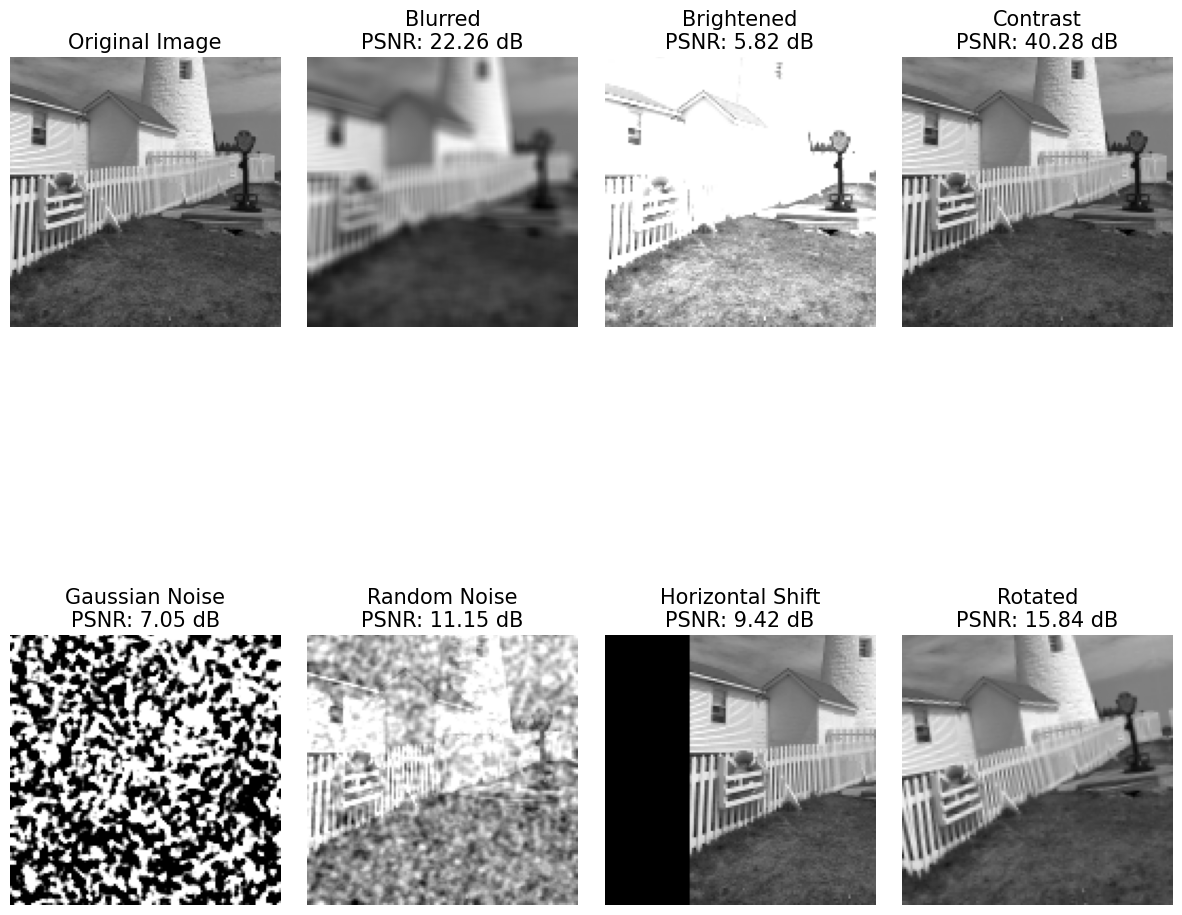

In [67]:
# === Select Input Image ===
_im = training_image_array[0]
im = cv.resize(_im, (128, 128), interpolation=cv.INTER_AREA)


# === Apply Attacks ===
blurred_im = Channel(im).blur_image(5)
brightened_im = Channel(im).brightness_attack(0.6)
contrast_im = Channel(im).contrast_attack(0.95)
gaussian_im = Channel(im).add_guassian_noise(0, 4)
shifted_im = Channel(im).x_shift_attack(40)
rotated_im = Channel(im).rotation_attack(10)
random_noise_im = Channel(im).add_random_noise(2)


# === Compute PSNR Values ===
psnr_blur = calculate_psnr(im, blurred_im)
psnr_brightness = calculate_psnr(im, brightened_im)
psnr_contrast = calculate_psnr(im, contrast_im)
psnr_gaussian = calculate_psnr(im, gaussian_im)
psnr_shift = calculate_psnr(im, shifted_im)
psnr_rotation = calculate_psnr(im, rotated_im)
psnr_random = calculate_psnr(im, random_noise_im)

# === Print PSNR Values ===
print(f"PSNR (Original vs. Blurred):        {psnr_blur:.2f} dB")
print(f"PSNR (Original vs. Brightened):     {psnr_brightness:.2f} dB")
print(f"PSNR (Original vs. Contrast):       {psnr_contrast:.2f} dB")
print(f"PSNR (Original vs. Gaussian Noise): {psnr_gaussian:.2f} dB")
print(f"PSNR (Original vs. X-Shifted):      {psnr_shift:.2f} dB")
print(f"PSNR (Original vs. Rotated):        {psnr_rotation:.2f} dB")
print(f"PSNR (Original vs. Random Noise):   {psnr_random:.2f} dB")

# === Plot All Images ===
titles = [
    ("Original Image", im),
    (f"Blurred\nPSNR: {psnr_blur:.2f} dB", blurred_im),
    (f"Brightened\nPSNR: {psnr_brightness:.2f} dB", brightened_im),
    (f"Contrast\nPSNR: {psnr_contrast:.2f} dB", contrast_im),
    (f"Gaussian Noise\nPSNR: {psnr_gaussian:.2f} dB", gaussian_im),
    (f"Random Noise\nPSNR: {psnr_random:.2f} dB", random_noise_im),
    (f"Horizontal Shift\nPSNR: {psnr_shift:.2f} dB", shifted_im),
    (f"Rotated\nPSNR: {psnr_rotation:.2f} dB", rotated_im),
]

plt.figure(figsize=(15, 15))  # You can slightly reduce the overall figure size if desired

for i, (title, img) in enumerate(titles):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title, fontsize=15)
    plt.axis('off')

# Adjust layout spacing
plt.subplots_adjust(wspace=0.1, hspace=0)  # Reduce horizontal and vertical space
plt.show()

# Split Image

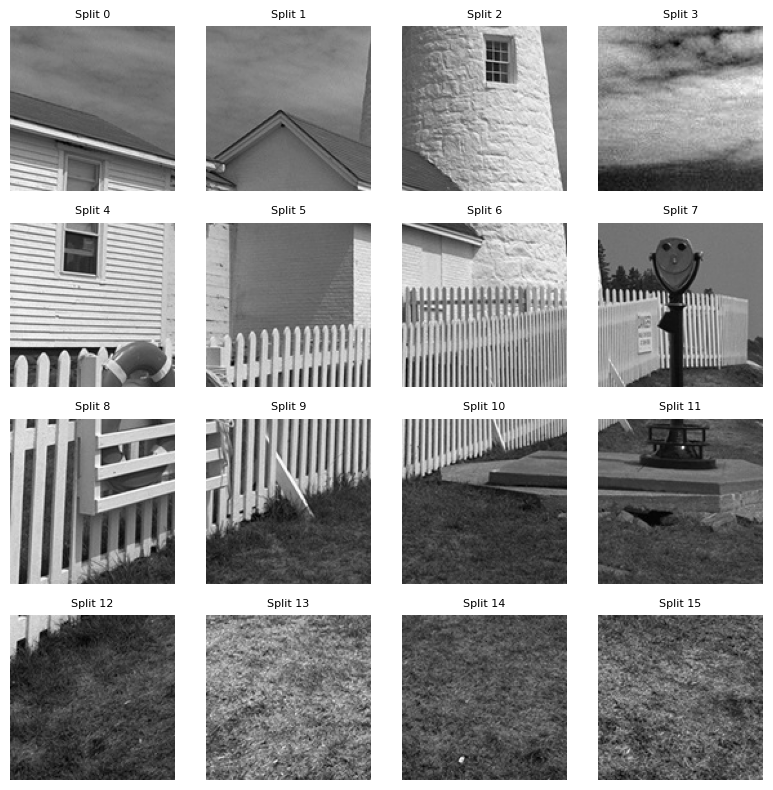

In [38]:
def get_image_split(im, split_num):
    """
    Splits a 512x512 grayscale image into 16 (128x128) blocks and returns the specified block.

    Parameters:
    - image: 2D numpy array of shape (512, 512)
    - split_num: Integer in [0, 15], indicating which split to return

    Returns:
    - 2D numpy array of shape (128, 128)
    """
    if im.shape != (512, 512):
        raise ValueError("Image must be 512x512.")
    if not (0 <= split_num < 16):
        raise ValueError("split_num must be in range 0 to 15.")

    row = split_num // 4
    col = split_num % 4

    start_y = row * 128
    start_x = col * 128

    return im[start_y:start_y + 128, start_x:start_x + 128]

# Example usage
def show_all_splits(im):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        split = get_image_split(im, i)
        row = i // 4
        col = i % 4
        axes[row, col].imshow(split, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Split {i}", fontsize=8)
    plt.tight_layout()
    plt.show()


show_all_splits(im)

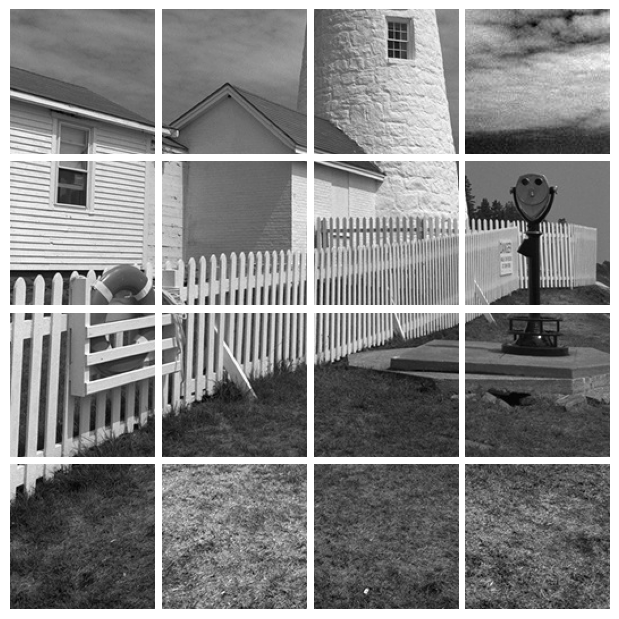

In [62]:
import matplotlib.pyplot as plt

def show_all_splits(im):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6),
                             gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    for i in range(16):
        split = get_image_split(im, i)
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        ax.imshow(split, cmap='gray', aspect='auto')
        ax.axis('off')  # Remove axis ticks
        # ax.set_title(f"Split {i}", fontsize=8)  # Optional: remove for a cleaner look

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01, hspace=0.01)
    plt.show()

show_all_splits(im)



# Embedding

In [25]:
import os
import cv2 as cv
import numpy as np

_folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Validation_512'

test_image_array = []
target_size = (512, 512)

for filename in os.listdir(_folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(_folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

        if my_image is None:
            print(f"Warning: Failed to load {filename}")
            continue

        # Resize if needed
        my_image = cv.resize(my_image, target_size)

        # Normalize to [0.0, 1.0]
        im = my_image.astype(np.float32) / 255.0

        test_image_array.append(im)



def complete_CNN_embedding(im, watermark_bits, mask_ratio):

  full_watermarked = np.zeros_like(im)  # same shape as im
  pn_dict = {}

  for split_num in range(16):  # 0 to 15 inclusive

    split_im = get_image_split(im, split_num)
    bit_pair = watermark_bits[2 * split_num : 2 * split_num + 2]

    watermarking = CNNWatermarking(split_im, mask_ratio)
    watermarked_block = watermarking.embedding(bit_pair)

    # Put watermarked block back into full image
    row = split_num // 4
    col = split_num % 4
    start_y = row * 128
    start_x = col * 128

    full_watermarked[start_y:start_y + 128, start_x:start_x + 128] = watermarked_block

  return full_watermarked



watermark_bits = np.random.choice([0, 1], size=32)
psnr_sum = 0
ssim_sum = 0
lpips_sum = 0
size = len(test_image_array)

for index in range(size):
  _im = test_image_array[index]
  w = complete_CNN_embedding(_im, watermark_bits, 0.5)

  psnr_sum = psnr_sum + calculate_psnr(_im, w)
  ssim_sum = ssim_sum + calculate_ssim(_im, w)
  lpips_sum = lpips_sum + calculate_lpips(_im, w)

print("Average PSNR:", psnr_sum / size)
print("Average SSIM:", ssim_sum / size)
print("Average LPIPS:", lpips_sum / size)




Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 151MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/pytho

KeyboardInterrupt: 

# CNN Transparency

40.26925


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

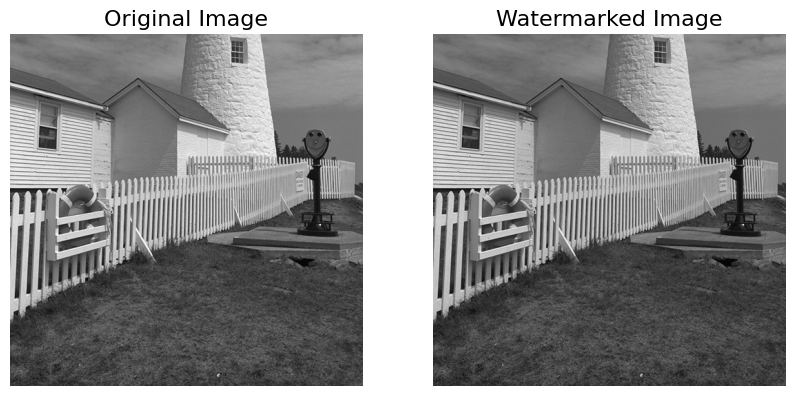

In [60]:
_im = training_image_array[0]
w = complete_CNN_embedding(_im, watermark_bits, 0.5)
print(calculate_psnr(_im, w))

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(_im, cmap='gray')
plt.title("Original Image", size = 16)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(w, cmap='gray')
plt.title("Watermarked Image", size = 16)
plt.axis('off')

# Traditional SSIS Transparency

40.00871336940155
0.9630354237848572
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
0.03772570192813873


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

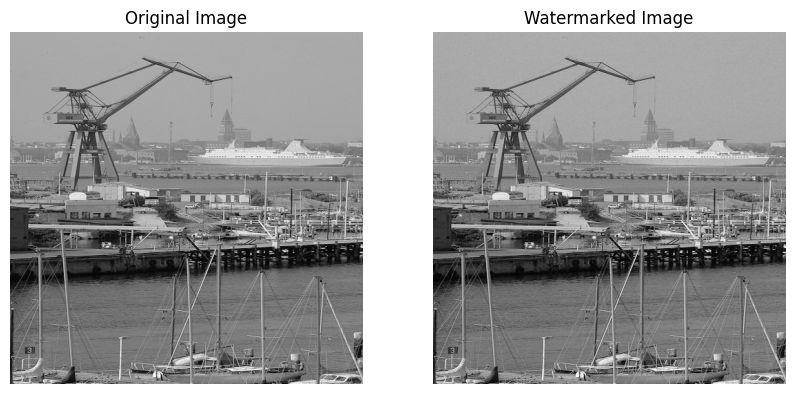

In [43]:
def _calculate_lpips(img1_np, img2_np, net='alex'):
    """
    img1_np, img2_np: numpy arrays (grayscale, normalized [0,1]), shape = (H, W)
    net: 'alex', 'vgg', or 'squeeze'
    """
    # Convert to torch tensors, shape: (1, 1, H, W)
    img1 = torch.tensor(img1_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    img2 = torch.tensor(img2_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Expand to 3 channels: (1, 3, H, W)
    img1 = img1.repeat(1, 3, 1, 1)
    img2 = img2.repeat(1, 3, 1, 1)

    # Normalize to [-1, 1]
    img1 = img1 * 2 - 1
    img2 = img2 * 2 - 1

    # Load LPIPS model
    loss_fn = lpips.LPIPS(net=net)
    with torch.no_grad():
        dist = loss_fn(img1, img2)
    return dist.item()




_im = training_image_array[1]

watermark_bits = np.random.choice([0, 1], size=32)

pn = PNSequences(_im).created_traditional_pn_array()
#pn = PNSequences(_im).created_hadamard_pn_array()
#pn = PNSequences(_im).created_advanced_pn_array(0.01)

w = Watermarking(_im, watermark_bits).embedding(0.01, pn)





print(calculate_psnr(_im, w))
print(calculate_ssim(_im, w))
print(_calculate_lpips(_im, w))

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(_im, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(w, cmap='gray')
plt.title("Watermarked Image")
plt.axis('off')



# DCT SSIS Transparency

5.6554894
0.0003572556351094859
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
1.0571774244308472


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

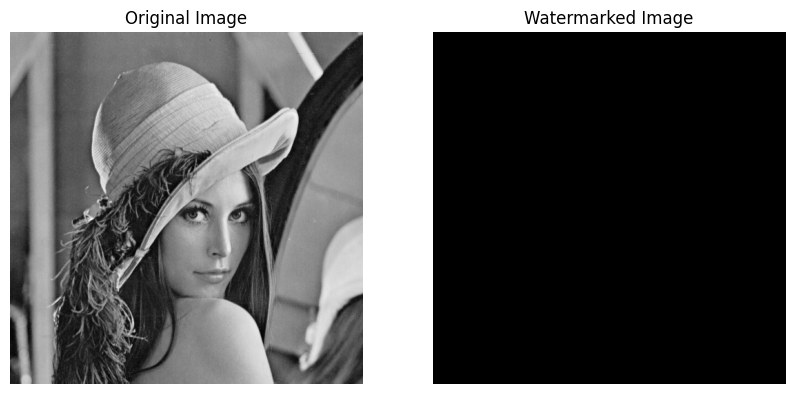

In [ ]:
_im = training_image_array[1]

watermark_bits = np.random.choice([0, 1], size=32)
pn = PNSequences(_im).created_traditional_pn_array()

w = DCTWatermarking(_im, watermark_bits).embedding(0.0001, pn)



print(calculate_psnr(_im, w))
print(calculate_ssim(_im, w))
print(_calculate_lpips(_im, w))

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(_im, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(w, cmap='gray')
plt.title("Watermarked Image")
plt.axis('off')
